In [207]:
import pandas as pd
import numpy as np
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import compose, pipeline, set_config, metrics
from sklearn import svm

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/luca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/luca/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/luca/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [148]:
set_config(display="diagram")

I start by following an online tutorial that uses Multinomial Naive Bayes with TfidfVectorizer.

In [3]:
yelp_data = pd.read_csv(
    'yelp_labelled.txt',
    sep ='\t',
    header = None,
    names = ['reviews', 'rating']
)

In [89]:
def preprocess_text(text):
    try:
        text = re.sub('[^a-zA-Z]', ' ', text)
        text = text.lower().split()
        text = [word for word in text if not word in set(nltk.corpus.stopwords.words('english'))]
        text = [nltk.stem.WordNetLemmatizer().lemmatize(word) for word in text if len(word) > 1]
        return ' '.join(text)
    except TypeError:
        return ''

def preprocess_series(series):
    texts = []
    for i in range(len(series)):
        texts.append(preprocess_text(series[i]))
    return pd.Series(texts)

    

In [116]:
X = preprocess_series(yelp_data["reviews"])
Y = yelp_data["rating"]

In [117]:
vectorizer = TfidfVectorizer(max_features = 4500)
X = vectorizer.fit_transform(X).toarray()

In [118]:
X.shape, Y.shape

((1000, 1766), (1000,))

In [119]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size = 0.2, random_state = 0
)

In [120]:
classifier = MultinomialNB()

In [121]:
classifier.fit(x_train, y_train)

MultinomialNB()

In [122]:
y_pred = classifier.predict(x_test)

In [123]:
accuracy_score(y_test, y_pred)

0.77

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.87      0.74      1016
           1       0.42      0.17      0.24       584

    accuracy                           0.61      1600
   macro avg       0.53      0.52      0.49      1600
weighted avg       0.56      0.61      0.56      1600



Now I will attempt to do the same but using the diabetes dataset with logisitic regression and support vector machines.

In [99]:
diabetes_data = pd.read_csv("8k_diabetes.csv", delimiter=',')

In [124]:
X = diabetes_data[["diag_1_desc", "diag_2_desc", "diag_3_desc"]]
for column_name in X:
    X[column_name] = preprocess_series(X[column_name])
Y = diabetes_data.loc[:,"readmitted"].astype(int)

/tmp/ipykernel_89214/3099938129.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column_name] = preprocess_series(X[column_name])


In [143]:
X.shape, Y.shape

((8000, 3), (8000,))

In [154]:
column_trans = compose.make_column_transformer(
    (TfidfVectorizer(), "diag_1_desc"),
    (TfidfVectorizer(), "diag_2_desc"),
    (TfidfVectorizer(), "diag_3_desc"),
     remainder="passthrough"
)

In [133]:
classifier = LogisticRegression(
    solver = "saga",
    penalty="elasticnet",
    l1_ratio=0.5,
    max_iter=10000
)

In [155]:
pipe = pipeline.make_pipeline(column_trans, classifier)

In [156]:
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidfvectorizer-1',
                                                  TfidfVectorizer(),
                                                  'diag_1_desc'),
                                                 ('tfidfvectorizer-2',
                                                  TfidfVectorizer(),
                                                  'diag_2_desc'),
                                                 ('tfidfvectorizer-3',
                                                  TfidfVectorizer(),
                                                  'diag_3_desc')])),
                ('logisticregression',
                 LogisticRegression(l1_ratio=0.5, max_iter=10000,
                                    penalty='elasticnet', solver='saga'))])

In [157]:
pipe.fit(X,Y);

/home/luca/anaconda3/envs/assignment2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


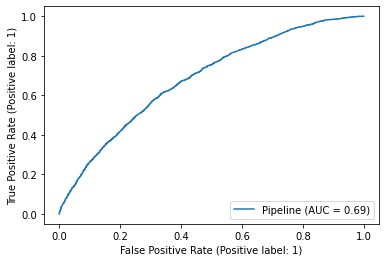

In [161]:
metrics.plot_roc_curve(pipe, X, Y)

In [192]:
X = diabetes_data[["diag_1_desc", "diag_2_desc", "diag_3_desc"]].fillna("").agg(' '.join, axis=1)

In [193]:
print(type(X))

<class 'pandas.core.series.Series'>


I will now attempt to merge the three diagnosis description columns row-wise in order to reduce dimensionality. 

In [194]:
X = pd.DataFrame({"diag_desc": preprocess_series(X)})
Y = diabetes_data.loc[:,"readmitted"].astype(int)

In [200]:
X

,diag_desc
0,spinal stenosis cervical region spinal stenosi...
1,first degree perineal laceration unspecified e...
2,pneumococcal pneumonia streptococcus pneumonia...
3,cellulitis abscess face streptococcus infectio...
4,bipolar disorder single manic episode unspecif...
...,...
7995,atherosclerosis aorta cerebral thrombosis with...
7996,disorder mineral metabolism alteration conscio...
7997,coronary atherosclerosis unspecified type vess...
7998,congestive heart failure unspecified paroxysma...


In [202]:
column_trans = compose.make_column_transformer(
    (TfidfVectorizer(), "diag_desc"),
     remainder="passthrough"
)

In [203]:
pipe = pipeline.make_pipeline(column_trans, classifier)

In [204]:
pipe.fit(X,Y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(),
                                                  'diag_desc')])),
                ('logisticregression',
                 LogisticRegression(l1_ratio=0.5, max_iter=10000,
                                    penalty='elasticnet', solver='saga'))])

/home/luca/anaconda3/envs/assignment2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


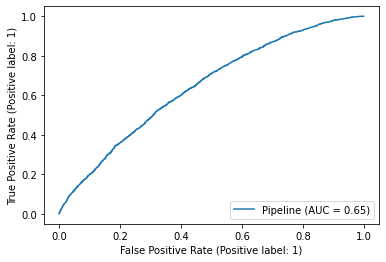

In [205]:
metrics.plot_roc_curve(pipe, X, Y)

Now I will try using an SVM with the text data.

In [209]:
classifier = svm.SVC()

In [210]:
pipe = pipeline.make_pipeline(column_trans, sv_classifier)

In [211]:
pipe.fit(X,Y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(),
                                                  'diag_desc')])),
                ('svc', SVC())])

/home/luca/anaconda3/envs/assignment2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


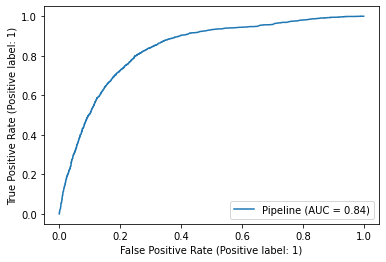

In [213]:
metrics.plot_roc_curve(pipe, X, Y)

In [214]:
X = diabetes_data[["diag_1_desc", "diag_2_desc", "diag_3_desc"]]
for column_name in X:
    X[column_name] = preprocess_series(X[column_name])
Y = diabetes_data.loc[:,"readmitted"].astype(int)

/tmp/ipykernel_89214/3099938129.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column_name] = preprocess_series(X[column_name])


In [215]:
column_trans = compose.make_column_transformer(
    (TfidfVectorizer(), "diag_1_desc"),
    (TfidfVectorizer(), "diag_2_desc"),
    (TfidfVectorizer(), "diag_3_desc"),
     remainder="passthrough"
)

In [216]:
pipe = pipeline.make_pipeline(column_trans, sv_classifier)

In [217]:
pipe.fit(X,Y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidfvectorizer-1',
                                                  TfidfVectorizer(),
                                                  'diag_1_desc'),
                                                 ('tfidfvectorizer-2',
                                                  TfidfVectorizer(),
                                                  'diag_2_desc'),
                                                 ('tfidfvectorizer-3',
                                                  TfidfVectorizer(),
                                                  'diag_3_desc')])),
                ('svc', SVC())])

/home/luca/anaconda3/envs/assignment2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


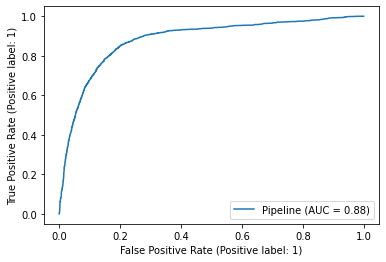

In [218]:
metrics.plot_roc_curve(pipe, X, Y)

/home/luca/anaconda3/envs/assignment2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


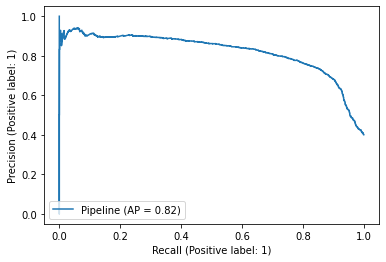

In [220]:
metrics.plot_precision_recall_curve(pipe, X, Y)

/home/luca/anaconda3/envs/assignment2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


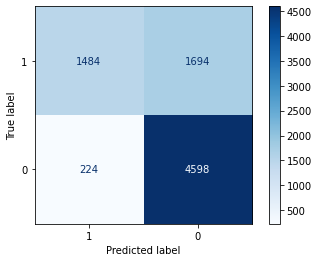

In [219]:
metrics.plot_confusion_matrix(pipe, X, Y, cmap="Blues", labels=[1,0])

In [237]:
column_trans = compose.make_column_transformer(
    (TfidfVectorizer(ngram_range=(1,2)), "diag_1_desc"),
    (TfidfVectorizer(ngram_range=(1,2)), "diag_2_desc"),
    (TfidfVectorizer(ngram_range=(1,2)), "diag_3_desc"),
     remainder="passthrough"
)

In [238]:
pipe = pipeline.make_pipeline(column_trans, sv_classifier)

In [239]:
pipe.fit(X,Y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidfvectorizer-1',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'diag_1_desc'),
                                                 ('tfidfvectorizer-2',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'diag_2_desc'),
                                                 ('tfidfvectorizer-3',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'diag_3_desc')])),
                ('svc', SVC())])

/home/luca/anaconda3/envs/assignment2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


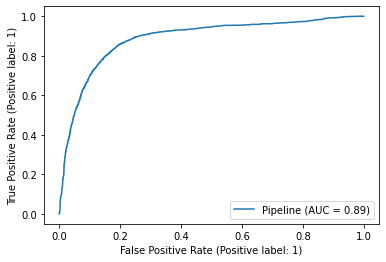

In [240]:
metrics.plot_roc_curve(pipe, X, Y)

0       0
1       0
2       1
3       0
4       0
       ..
7995    0
7996    0
7997    0
7998    0
7999    1
Name: readmitted, Length: 8000, dtype: int64